In [145]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt


In [146]:
folder_base = './results_qb'
folder_baseline = './results_baseline'
folder_nonlinear = './results_nonlinear'

csv_file_base = 'base_results_summary.csv'
csv_file_nonlinear = 'nonlinear_results_summary.csv'

figures_folder = './figures'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)


In [147]:
# Define a function to process a single file
def process_file(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    # Extract columns, using placeholders for missing data
    scenario_name = data.get("model_file", "-").replace('.json', '')
    algorithm = data.get("configuration", {}).get("algorithm", "-")
    size = data.get("configuration", {}).get("size", "-")
    optimizer = data.get("configuration", {}).get("optimizer", "-")
    annealings = data.get("configuration", {}).get("nonlinear_annealings", "-")
    iterations = data.get("configuration", {}).get("nonlinear_iterations", "-")

    reasoner = data.get("reasoner_results", {})
    if isinstance(reasoner, str):
        print(f"File {filepath} has reasoner results as a string, converting to dict.")
        reasoner = {"status": reasoner}
    status = reasoner.get("status", "-")
    score = reasoner.get("score", "-")
    evaluation = reasoner.get("evaluation", "-")
    exec_time = reasoner.get("solver_exec_time", "-")
    total_cost = reasoner.get("total_cost", "-")
    max_time = reasoner.get("max_time", "-")
    min_fidelity = reasoner.get("min_fidelity", "-")
    dispatch = reasoner.get("dispatch", {})

    if optimizer == "linear":
        baseline = "qb-linear"
    elif optimizer == "nonlinear":
        baseline = "qb-nonlinear"
    else:
        baseline = "unknown"
    
    # Row for DataFrame
    row = {
        "baseline": baseline,
        "scenario_name": scenario_name,
        "algorithm": algorithm,
        "size": size,
        "optimizer": optimizer,
        "annealings": annealings,
        "iterations": iterations,
        "status": status,
        "score": score,
        "evaluation": evaluation,
        "exec_time": exec_time,
        "total_cost": total_cost,
        "max_time": max_time,
        "min_fidelity": min_fidelity
    }
    
    # Key for dispatches dict
    dispatch_key = (scenario_name, algorithm, size, optimizer, annealings, iterations)
    
    return row, dispatch_key, dispatch

In [148]:
def process_file_baseline(filepath, scenario_name):
    with open(filepath, 'r') as f:
        data = json.load(f)
    algorithm = data.get("algorithm", "-")
    size = data.get("size", "-")
    optimizer = "-"  
    annealings = "-"
    iterations = "-"
    status = "-" 
    score = "-"
    evaluation =  data.get(scenario_name+"_value", "-")
    exec_time = "-"
    total_cost = data.get("total_cost", "-")
    max_time = data.get("max_time", "-")
    min_fidelity = data.get("min_fidelity", "-")
    dispatch = data.get("dispatch", {})
    baseline = os.path.basename(filepath).replace(algorithm+"_", "").replace(str(size)+"_", "").replace(".json", "")
    row = {
        "baseline": baseline,
        "scenario_name": scenario_name,
        "algorithm": algorithm,
        "size": size,
        "optimizer": optimizer,
        "annealings": annealings,
        "iterations": iterations,
        "status": status,
        "score": score,
        "evaluation": evaluation,
        "exec_time": exec_time,
        "total_cost": total_cost,
        "max_time": max_time,
        "min_fidelity": min_fidelity
    }
    dispatch_key = (scenario_name, algorithm, size, optimizer, annealings, iterations)
    return row, dispatch_key, dispatch

In [149]:
data_rows = []
dispatches = {}

if os.path.exists(csv_file_base):
    df = pd.read_csv(csv_file_base)    
else:
    base_files = [os.path.join(folder_base, f) for f in os.listdir(folder_base) if f.endswith('.json')]
    baseline_files = [os.path.join(folder_baseline, f) for f in os.listdir(folder_baseline) if f.endswith('.json')]
    for file in base_files:
        row, key, dispatch = process_file(file)
        data_rows.append(row)
        dispatches[key] = dispatch
    
    for file in baseline_files:
        for scenario_name in ["scenario1", "scenario2", "scenario3"]:
            row, key, dispatch = process_file_baseline(file, scenario_name)
            data_rows.append(row)
            if key in dispatches:
                continue
            else:
                dispatches[key] = dispatch

    # Create DataFrame
    df = pd.DataFrame(data_rows)
    df.to_csv(csv_file_base, index=False)

# Show results
print("DataFrame:")
df['algorithm'] = df['algorithm'].replace('realamprandom', 'realamprnd')
df['algorithm'] = df['algorithm'].replace('twolocalrandom', 'twolocalrnd')
display(df)

#print("\nDispatches dictionary (keys and values):")
#for k, v in dispatches.items():
#    print(f"{k}: {v}")



DataFrame:


,baseline,scenario_name,algorithm,size,optimizer,annealings,iterations,status,score,evaluation,exec_time,total_cost,max_time,min_fidelity
0,qb-linear,scenario1,qaoa,6,linear,-,-,no_solution_found,-,-,0.013695746660232544,-,-,-
1,qb-linear,scenario1,qaoa,8,linear,-,-,no_solution_found,-,-,0.013314703479409218,-,-,-
2,qb-linear,scenario1,qnn,8,linear,-,-,solution_found,536.4831160074561,317.0453467369869,0.02147061564028263,247.13069347397382,386.96000000000004,0.9384
3,qb-linear,scenario3,qft,10,linear,-,-,solution_found,265.6,229.51999999999998,0.01776919700205326,200.07617253840908,229.51999999999998,0.9564
4,qb-nonlinear,scenario2,qaoa,10,nonlinear,10,40,solution_found,-669.9266498060908,669.9266498060908,25.77796712704003,669.9266498060908,1699.3200000000002,0.8621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,all_sherbrooke,scenario2,qaoa,8,-,-,-,-,-,-225.16516748774657,-,225.16516748774657,2542.6700000000005,0.9037
500,all_sherbrooke,scenario3,qaoa,8,-,-,-,-,-,2542.6700000000005,-,225.16516748774657,2542.6700000000005,0.9037
501,all_fez,scenario1,qnn,8,-,-,-,-,-,810.465806011304,-,362.01161202260806,1258.92,0.9454
502,all_fez,scenario2,qnn,8,-,-,-,-,-,-362.01161202260806,-,362.01161202260806,1258.92,0.9454


In [150]:
df.columns



Index(['baseline', 'scenario_name', 'algorithm', 'size', 'optimizer',
       'annealings', 'iterations', 'status', 'score', 'evaluation',
       'exec_time', 'total_cost', 'max_time', 'min_fidelity'],
      dtype='object')

In [151]:
_df = df[df['status'].isin(['solution_found', '-'])]
#_df = _df[_df['algorithm'] != 'ghz']
#_df = _df[_df['algorithm'] != 'qpeexact']
#_df = _df[_df['algorithm'] != 'wstate']

# Coerce total_cost to numeric (any non-numeric becomes NaN) and drop those rows
_df['total_cost'] = pd.to_numeric(_df['total_cost'], errors='coerce')
_df['max_time'] = pd.to_numeric(_df['max_time'], errors='coerce')
_df['min_fidelity'] = pd.to_numeric(_df['min_fidelity'], errors='coerce')
_df['evaluation'] = pd.to_numeric(_df['evaluation'], errors='coerce')

_df = _df.dropna(subset=['total_cost'])
_df = _df.dropna(subset=['max_time'])
_df = _df.dropna(subset=['min_fidelity'])
_df = _df.dropna(subset=['evaluation'])

# Sort by algorithm name and size
_df = _df.sort_values(['algorithm', 'size'], ascending=[True, True])
_df['alg_size'] = _df['algorithm'] + '-' + _df['size'].astype(int).astype(str)

my_baselines = {'qb-linear', 'qb-nonlinear'}

constraints = { "scenario1": {"total_cost": 800, "max_time": 2000, "min_fidelity": 0.9},
               "scenario2": {"total_cost": 750, "max_time": 1600, "min_fidelity": 0.85},
               "scenario3": {"total_cost": 700, "max_time": 0, "min_fidelity": 0} }



/tmp/ipykernel_15950/802354852.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['total_cost'] = pd.to_numeric(_df['total_cost'], errors='coerce')
/tmp/ipykernel_15950/802354852.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['max_time'] = pd.to_numeric(_df['max_time'], errors='coerce')
/tmp/ipykernel_15950/802354852.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

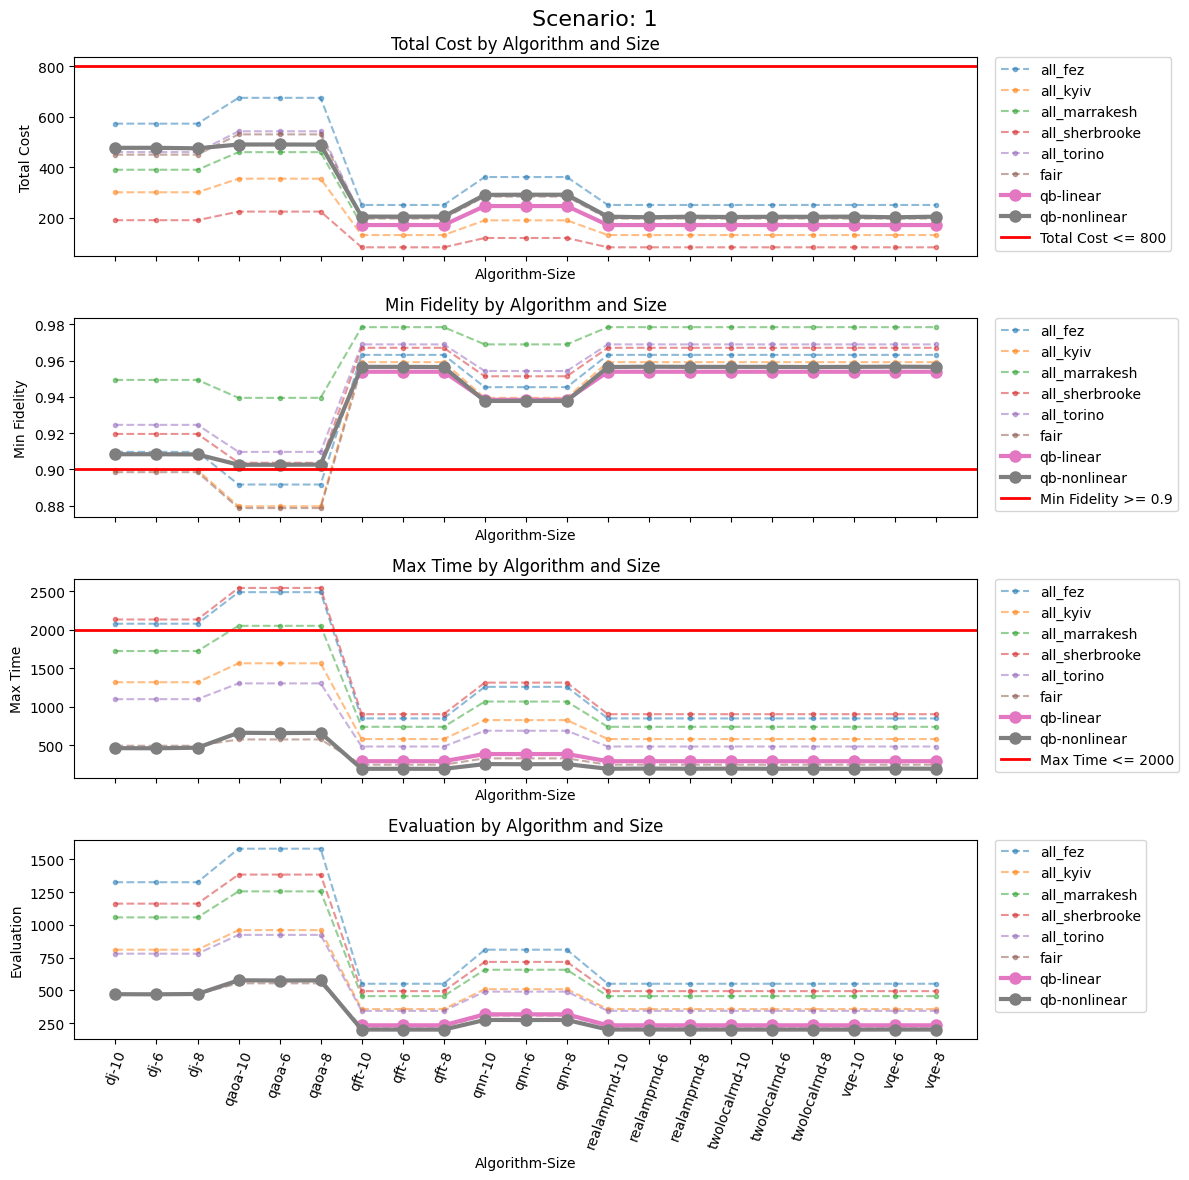

In [ ]:
#SCENARIO 1
_df1 = _df[_df['scenario_name'] == "scenario1"]

fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
fig.suptitle(f"Scenario: 1", fontsize=16)

for i, ycol in enumerate(['total_cost', 'min_fidelity', 'max_time', 'evaluation']):

    pivot = _df1.pivot(
        index='alg_size',
        columns='baseline',
        values=ycol
    )
    

    axes[i].set_title(f'{ycol.replace("_", " ").title()} by Algorithm and Size')
    for baseline in pivot.columns:
        if baseline in my_baselines:
            axes[i].plot(pivot.index, pivot[baseline], marker='o', linewidth=3, markersize=8, label=baseline)
        else:
            axes[i].plot(pivot.index, pivot[baseline], marker='.', linestyle='--', alpha=0.5, label=baseline)

    if ycol != 'evaluation':
        constraint_value = constraints["scenario1"][ycol]
        if ycol == 'total_cost':
            axes[i].axhline(y=constraint_value, color='red', linestyle='-', linewidth=2, label=f"Total Cost <= {constraint_value}")
        elif ycol == 'max_time':
            axes[i].axhline(y=constraint_value, color='red', linestyle='-', linewidth=2, label=f"Max Time <= {constraint_value}")
        else:
            axes[i].axhline(y=constraint_value, color='red', linestyle='-', linewidth=2, label=f"Min Fidelity >= {constraint_value}")
    axes[i].set_xlabel('Algorithm-Size')
    axes[i].set_ylabel('Total Cost' if ycol == 'total_cost' else 'Max Time' if ycol == 'max_time' else 'Min Fidelity' if ycol == 'min_fidelity' else 'Objective Value')
    axes[i].tick_params(axis='x', rotation=70)
    axes[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.savefig(f'{figures_folder}/scenario1_analysis.pdf', format="pdf", bbox_inches='tight')
plt.show()

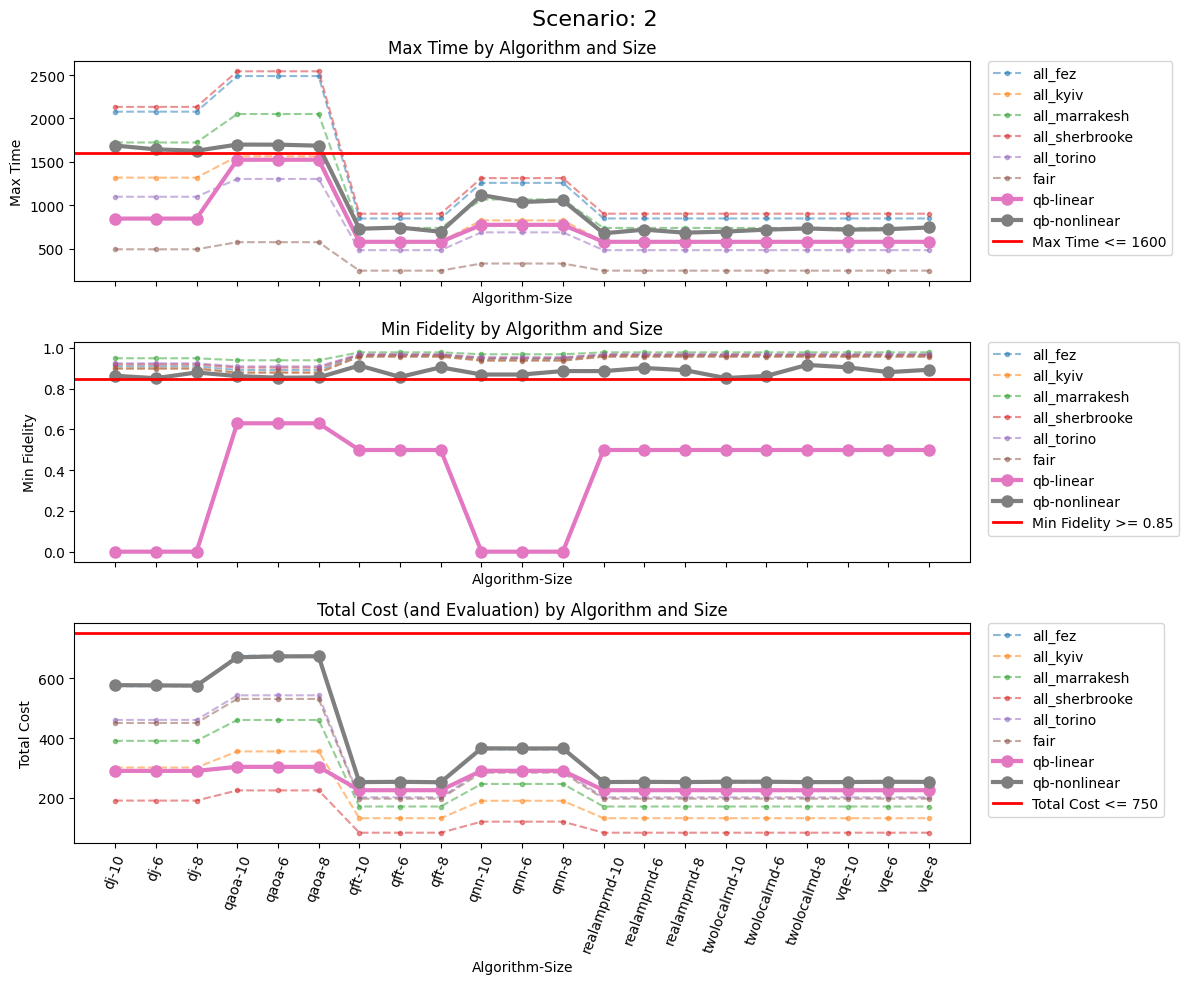

In [153]:
#SCENARIO 2
_df2 = _df[_df['scenario_name'] == "scenario2"]

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
fig.suptitle(f"Scenario: 2", fontsize=16)

for i, ycol in enumerate(['max_time','min_fidelity', 'total_cost']):

    pivot = _df2.pivot(
        index='alg_size',
        columns='baseline',
        values=ycol
    )
    

    axes[i].set_title(f'{ycol.replace("_", " ").title()} by Algorithm and Size')
    for baseline in pivot.columns:
        if baseline in my_baselines:
            axes[i].plot(pivot.index, pivot[baseline], marker='o', linewidth=3, markersize=8, label=baseline)
        else:
            axes[i].plot(pivot.index, pivot[baseline], marker='.', linestyle='--', alpha=0.5, label=baseline)

    constraint_value = constraints["scenario2"][ycol]
    if ycol == 'total_cost':
        axes[i].set_title(f'{ycol.replace("_", " ").title()} (and Evaluation) by Algorithm and Size')
        axes[i].axhline(y=constraint_value, color='red', linestyle='-', linewidth=2, label=f"Total Cost <= {constraint_value}")
    elif ycol == 'max_time':
        axes[i].axhline(y=constraint_value, color='red', linestyle='-', linewidth=2, label=f"Max Time <= {constraint_value}")
    else:
        axes[i].axhline(y=constraint_value, color='red', linestyle='-', linewidth=2, label=f"Min Fidelity >= {constraint_value}")
    axes[i].set_xlabel('Algorithm-Size')
    axes[i].set_ylabel('Total Cost' if ycol == 'total_cost' else 'Max Time' if ycol == 'max_time' else 'Min Fidelity' if ycol == 'min_fidelity' else 'Evaluation')
    axes[i].tick_params(axis='x', rotation=70)
    axes[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.savefig(f'{figures_folder}/scenario2_analysis.pdf', format="pdf", bbox_inches='tight')
plt.show()

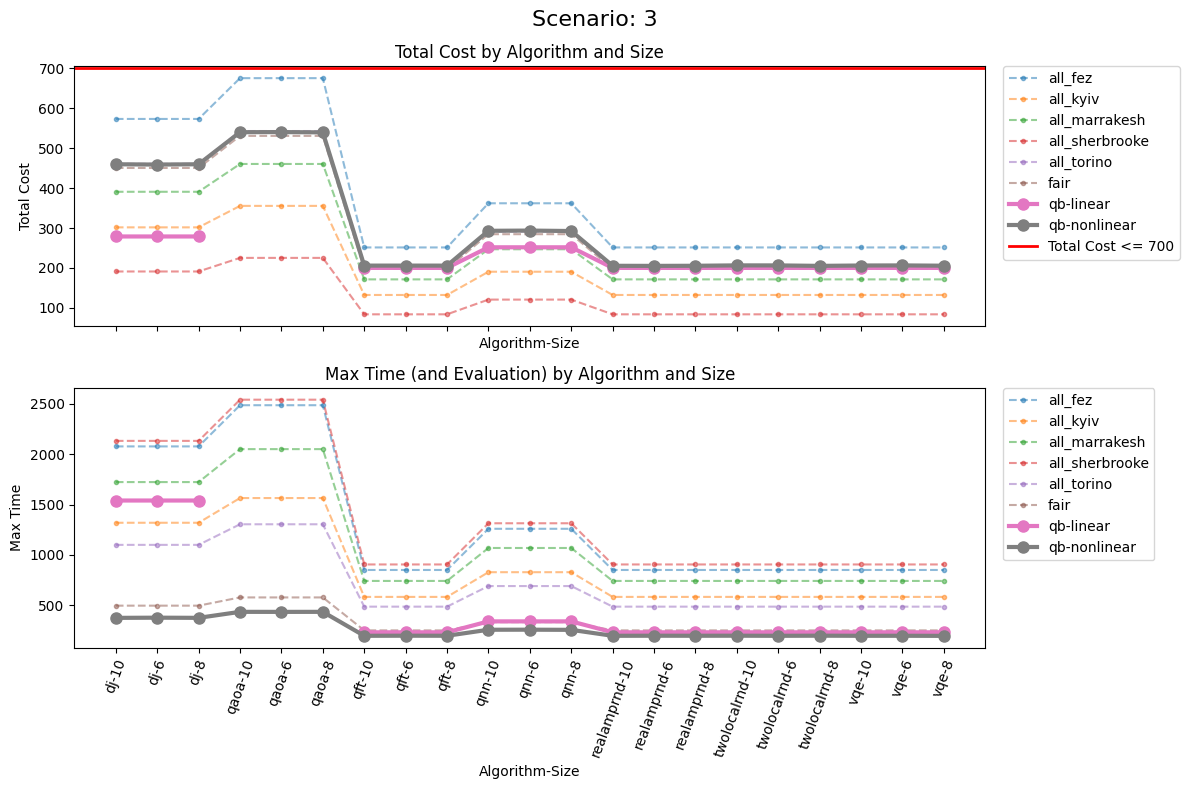

In [154]:
#SCENARIO 3
_df3 = _df[_df['scenario_name'] == "scenario3"]

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle(f"Scenario: 3", fontsize=16)

for i, ycol in enumerate(['total_cost', 'max_time']):

    pivot = _df3.pivot(
        index='alg_size',
        columns='baseline',
        values=ycol
    )
    

    axes[i].set_title(f'{ycol.replace("_", " ").title()} by Algorithm and Size')
    for baseline in pivot.columns:
        if baseline in my_baselines:
            axes[i].plot(pivot.index, pivot[baseline], marker='o', linewidth=3, markersize=8, label=baseline)
        else:
            axes[i].plot(pivot.index, pivot[baseline], marker='.', linestyle='--', alpha=0.5, label=baseline)

    constraint_value = constraints["scenario3"][ycol]
    if ycol == 'total_cost':
        axes[i].axhline(y=constraint_value, color='red', linestyle='-', linewidth=2, label=f"Total Cost <= {constraint_value}")
    else:
        axes[i].set_title(f'{ycol.replace("_", " ").title()} (and Evaluation) by Algorithm and Size')
    
    axes[i].set_xlabel('Algorithm-Size')
    axes[i].set_ylabel('Total Cost' if ycol == 'total_cost' else 'Max Time' if ycol == 'max_time' else 'Min Fidelity' if ycol == 'min_fidelity' else 'Evaluation')
    axes[i].tick_params(axis='x', rotation=70)
    axes[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.savefig(f'{figures_folder}/scenario3_analysis.pdf', format="pdf", bbox_inches='tight')
plt.show()

In [155]:
df_filtered = df[df['baseline'].isin(['qb-linear', 'qb-nonlinear']) & 
                 df['scenario_name'].isin(['scenario1', 'scenario2', 'scenario3'])]

df_filtered['exec_time'] = pd.to_numeric(df_filtered['exec_time'], errors='coerce')
df_filtered['evaluation'] = pd.to_numeric(df_filtered['evaluation'], errors='coerce')

# Individuate failed configurations
failed = df_filtered[df_filtered['status'] != 'solution_found']
config_cols = ['scenario_name', 'algorithm', 'size']
# Create a set of failed configurations
failed_configs = set(tuple(x) for x in failed[config_cols].to_numpy())
# Filter out failed configurations
filtered_df = df_filtered[~df_filtered[config_cols].apply(tuple, axis=1).isin(failed_configs)]

grouped = filtered_df.groupby(['baseline', 'scenario_name'])[['exec_time', 'evaluation']].mean().reset_index()

# 3. Pivot the table to get the desired format
table = grouped.pivot(index='baseline', columns='scenario_name')

# 4. Flatten the MultiIndex columns
table.columns = [f"{col[1]}_{col[0]}" for col in table.columns]
table = table.reset_index()

# Total count per baseline and scenario
total_counts = df_filtered.groupby(['baseline', 'scenario_name']).size().reset_index(name='total_count')

# Count where status != 'solution_found'
not_found_counts = df_filtered[df_filtered['status'] != 'solution_found'] \
    .groupby(['baseline', 'scenario_name']).size().reset_index(name='not_found_count')

# Merge and calculate percentage
counts = pd.merge(total_counts, not_found_counts, on=['baseline', 'scenario_name'], how='left')
counts['not_found_count'] = counts['not_found_count'].fillna(0)
counts['not_found_percent'] = 100 * counts['not_found_count'] / counts['total_count']

# Keep only necessary columns
percent_df = counts[['baseline', 'scenario_name', 'not_found_percent']]

percent_table = percent_df.pivot(index='baseline', columns='scenario_name', values='not_found_percent')
percent_table = percent_table.add_prefix('scenario_').add_suffix('_not_found_percent').reset_index()

# Merge with the main summary table you already created (called 'table' above)
final_table = pd.merge(table, percent_table, on='baseline', how='left')

# Optional: Clean up the column names for readability
final_table.columns = [col.replace('scenario_', '').replace('_not_found_percent', '_not_found_percent') 
                      if 'not_found_percent' in col else col for col in final_table.columns]


display(final_table)

/tmp/ipykernel_15950/2646627996.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['exec_time'] = pd.to_numeric(df_filtered['exec_time'], errors='coerce')
/tmp/ipykernel_15950/2646627996.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['evaluation'] = pd.to_numeric(df_filtered['evaluation'], errors='coerce')


,baseline,scenario1_exec_time,scenario2_exec_time,scenario3_exec_time,scenario1_evaluation,scenario2_evaluation,scenario3_evaluation,scenario1_not_found_percent,scenario2_not_found_percent,scenario3_not_found_percent
0,qb-linear,0.021446,0.079169,0.017806,249.835105,255.46209,466.065000,28.571429,0.0,14.285714
1,qb-nonlinear,23.912632,22.586154,15.969213,215.194526,375.34910,234.937222,0.000000,0.0,0.000000
